<a href="https://colab.research.google.com/github/abhishekanand1710/not-too-similar/blob/main/Sample_Dataset_using_Sentence_Transfomers_and_FAISS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "drive/MyDrive/Youtube Comments Relevancy/data"
%pwd

/content/drive/MyDrive/Youtube Comments Relevancy/data


'/content/drive/MyDrive/Youtube Comments Relevancy/data'

In [3]:
%ls

youtube-comments-categorization.csv


In [4]:
!pip install sentence-transformers
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 101.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 66.2 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=c421df442ea4928b3063593e92b923c2b10de80d28982ded51464e10af900d37
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from string import digits
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import re
from tqdm import tqdm, notebook
from sentence_transformers import SentenceTransformer, models, util
import time

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from transformers import AutoModel
from transformers import AutoTokenizer
from transformers import AutoConfig

In [8]:
import os
import random
import gc
from pprint import pprint

sns.set(style='darkgrid')

from sklearn.model_selection import train_test_split

%matplotlib inline

In [9]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: ', device.type)

SEED = 97
seed_everything(SEED)

Device:  cuda


In [10]:
DATA_PATH = "./youtube-comments-categorization.csv"

In [11]:
cfg = {}
BERT = 'bert-base-uncased'
DISTIL_BERT = 'distilbert-base-uncased'
ROBERTA = 'roberta-base'
MODEL_PATH = DISTIL_BERT

In [12]:
df = pd.read_csv(DATA_PATH, header = None)
df.columns = ['comment', 'label']
df.head()

,comment,label
0,Love you sir!!,positive
1,Please make videos on..Midpoint circle drawing...,imperative
2,I bought both of your courses on Udemy. You ar...,interrogative
3,"Thank you very much, u really got me in the fi...",positive
4,i hope u are ok with everything going on again...,miscellaneous


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  10000 non-null  object
 1   label    10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


<ipython-input-14-b268d4bc4316>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=labels, rotation=45)


<Axes: xlabel='label', ylabel='count'>

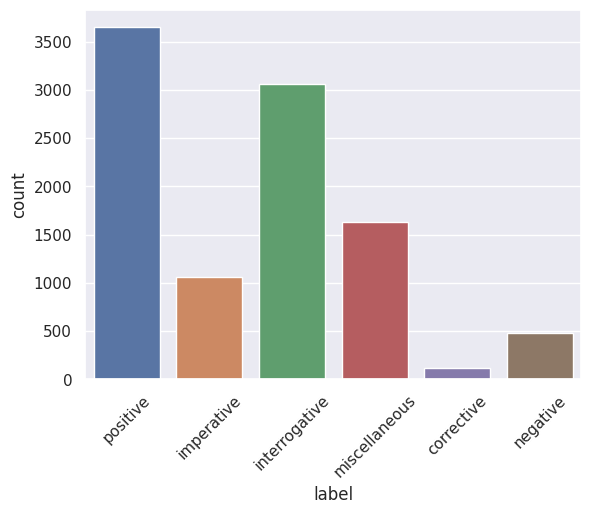

In [14]:
_, ax = plt.subplots()
labels = df.label.unique()
ax.set_xticklabels(labels=labels, rotation=45)
sns.countplot(x='label', data=df, ax=ax)

In [15]:
df.label.unique()
labels = {'positive':0, 'imperative':1, 'interrogative':2, 'miscellaneous':3,
       'corrective':4, 'negative':5}
df['enc_label'] = df.label.apply(lambda x: labels[x])
df.head()

,comment,label,enc_label
0,Love you sir!!,positive,0
1,Please make videos on..Midpoint circle drawing...,imperative,1
2,I bought both of your courses on Udemy. You ar...,interrogative,2
3,"Thank you very much, u really got me in the fi...",positive,0
4,i hope u are ok with everything going on again...,miscellaneous,3


In [16]:
X_train, X_temp, y_train, y_temp = train_test_split(df.comment, df.enc_label, test_size=0.8, random_state=SEED, stratify=df.enc_label)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp)

In [17]:
len(X_train), len(X_val), len(X_test)

(2000, 4000, 4000)

In [18]:
train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
val_df = pd.concat([X_val, y_val], axis=1).reset_index(drop=True)
test_df = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

In [19]:
train_df.head()

,comment,enc_label
0,MBA In marketing VS Mba in operation managemen...,2
1,Bro la kati ma parddi hununx ani batchlor ma k...,3
2,You obviously lack a lot of the fundamental kn...,5
3,4:13 i see u rick astley,3
4,"Mate, this was very cool. I'd never heard of i...",0


In [20]:
cfg['tokenizer'] ={'name': MODEL_PATH, 'max_length': 256}
tokenizer = AutoTokenizer.from_pretrained(cfg['tokenizer']['name'])

In [21]:
cfg['train_batch_size'] = 32
cfg['valid_batch_size'] = 16
cfg['max_length'] = 256
cfg['epochs'] = 3
cfg['learning_rate'] = 1e-05

In [22]:
class CommentsDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.len = len(df)
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        comment = self.df.loc[index, 'comment']
        inputs = self.tokenizer.encode_plus(
            comment,                                 
            add_special_tokens=True,
            padding='max_length',
            max_length=self.max_len,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        
        if cfg['tokenizer']['name']=='bert-base-uncased':
            token_type_ids = inputs['token_type_ids'] 
        else:
            token_type_ids = 1.
        
        target = self.df.loc[index, 'enc_label']
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'masks': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(target, dtype=torch.long)
        }
    
    def __len__(self):
        return self.len

In [23]:
train_data = CommentsDataset(train_df, tokenizer, cfg['max_length'])
val_data = CommentsDataset(val_df, tokenizer, cfg['max_length'])
test_data = CommentsDataset(test_df, tokenizer, cfg['max_length'])

In [24]:
train_params = {'batch_size': cfg['train_batch_size'],
                'shuffle': True,
                'num_workers': 0
                }

valid_params = {'batch_size': cfg['valid_batch_size'],
                'shuffle': False,
                'num_workers': 0
                }

test_params = {'batch_size': cfg['valid_batch_size'],
                'shuffle': False,
                'num_workers': 0
                }

train_loader = DataLoader(train_data, **train_params)
val_loader = DataLoader(val_data, **valid_params)
test_loader = DataLoader(test_data, **test_params)

In [25]:
class CommentRelevanceBERT(torch.nn.Module):
    def __init__(self, model_name, dropout=True):
        super(CommentRelevanceBERT, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.model_name = model_name
        
        if model_name == BERT:
            self.in_features = self.bert.pooler.dense.out_features
        elif model_name == DISTIL_BERT:
            self.in_features = self.bert.transformer.layer[5].output_layer_norm.normalized_shape[0]
        elif model_name == ROBERTA:
            self.in_features = self.bert.pooler.dense.out_features
        else:
            self.in_features = 768
            
        self.dense = nn.Linear(self.in_features, self.in_features)
        self.activation = nn.ReLU()
        self.layer_norm = nn.LayerNorm(self.in_features)
        # self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, len(labels))

    def forward(self, input_ids, attention_mask, token_type_ids):    
        if self.model_name == BERT:
            last_hidden_state, output = self.bert(input_ids,
                                                  attention_mask=attention_mask,
                                                  token_type_ids=token_type_ids,
                                                  return_dict=False)
        elif self.model_name == DISTIL_BERT:
            last_hidden_state = self.bert(input_ids,
                                          attention_mask=attention_mask,
                                          return_dict=False)
            first_token_tensor = last_hidden_state[0][:, 0]
            output = self.dense(first_token_tensor)
            output = self.activation(output)
            
        elif self.model_name == ROBERTA:
            last_hidden_state, output = self.bert(input_ids,
                                                  attention_mask=attention_mask,
                                                  return_dict=False)
        
        output = self.layer_norm(output)
        # output = self.dropout(output)
        output = self.classifier(output)
        return output

In [26]:
model = CommentRelevanceBERT(MODEL_PATH)
model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CommentRelevanceBERT(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Li

In [27]:
from torch.optim.lr_scheduler import StepLR
from transformers import get_cosine_schedule_with_warmup

In [28]:
num_training_steps = cfg['epochs']*len(train_loader)
num_warmup_steps = 0
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=cfg['learning_rate'])
scheduler = get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
)

In [29]:
def calc_accuracy(preds, targets):
    accuracy = (preds==targets).cpu().numpy().mean() * 100
    return accuracy

In [30]:
def train(model, loss_fn, train_dataloader, val_dataloader=None, epochs=3, evaluation=False):
    
    print("Start training...\n")
    for epoch in range(epochs):
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        t0_epoch, t0_batch = time.time(), time.time()

        total_loss, batch_loss, batch_counts = 0, 0, 0
        train_loss = []
        model.train()

        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            model.zero_grad()
            input_ids = batch['ids'].to(device, dtype = torch.long)
            attention_mask = batch['masks'].to(device, dtype = torch.long)
            token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
            targets = batch['targets'].to(device, dtype = torch.long)

            outputs = model(input_ids, attention_mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            train_loss.append(loss.item())
            
            batch_loss += loss.item()
            total_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                time_elapsed = time.time() - t0_batch

                print(f"{epoch + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        
        if evaluation == True:
            val_loss, val_accuracy = evaluate(model, loss_fn, val_dataloader)
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            
            print("-"*70)
        print("\n")
    
    print("Training complete!")

In [31]:
def evaluate(model, loss_fn, val_dataloader):
    model.eval()

    val_accuracy = []
    val_loss = []

    for batch in val_dataloader:
        input_ids = batch['ids'].to(device, dtype = torch.long)
        attention_mask = batch['masks'].to(device, dtype = torch.long)
        token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.long)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask, token_type_ids)
        
        loss = loss_fn(outputs, targets)
        val_loss.append(loss.item())

        _, max_ids = torch.max(outputs.data, dim=1)
        val_accuracy.append(calc_accuracy(max_ids, targets))

    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [32]:
train(model, loss_function, train_loader, val_loader, epochs=5, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.508770   |     -      |     -     |   17.86  
   1    |   40    |   1.070679   |     -      |     -     |   12.00  
   1    |   60    |   0.883594   |     -      |     -     |   12.00  
   1    |   62    |   0.938613   |     -      |     -     |   0.92   
----------------------------------------------------------------------
   1    |    -    |   1.153124   |  0.725627  |   77.08   |   70.05  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.685058   |     -      |     -     |   13.03  
   2    |   40    |   0.624318   |     -      |     -     |   12.55  
   2    |   60    |   0.674182   |     -      |     -     |   12.

In [33]:
test_loss, test_accuracy = evaluate(model, loss_function, test_loader)
test_loss, test_accuracy

(0.5936297713518143, 79.725)

In [34]:
def predict(model, loss_fn, val_dataloader):
    model.eval()

    preds = []

    for batch in val_dataloader:
        input_ids = batch['ids'].to(device, dtype = torch.long)
        attention_mask = batch['masks'].to(device, dtype = torch.long)
        token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.long)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask, token_type_ids)
        
        loss = loss_fn(outputs, targets)
        _, max_ids = torch.max(outputs.data, dim=1)
        preds.extend(max_ids.cpu().numpy())

    return preds

In [35]:
preds = predict(model, loss_function, test_loader)
len(preds), len(test_df)

(4000, 4000)

In [36]:
from sklearn.metrics import classification_report

In [37]:
report = classification_report(y_test, preds, labels=[0, 1, 2, 3, 4, 5])
print(report)

              precision    recall  f1-score   support

           0       0.86      0.90      0.87      1459
           1       0.67      0.65      0.66       423
           2       0.90      0.92      0.91      1223
           3       0.59      0.72      0.65       653
           4       0.00      0.00      0.00        49
           5       0.60      0.09      0.16       193

    accuracy                           0.80      4000
   macro avg       0.60      0.55      0.54      4000
weighted avg       0.78      0.80      0.78      4000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
